In [2]:
import numpy as np
import cv2
import torch
import json
import matplotlib.pyplot as plt

# Using YOLO/Detectron2 to segment

## Using Detectron2

In [13]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2.git
dist = distutils.core.run_setup("./detectron2/setup.py")
!python3 -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# python -m pip install git+https://github.com/facebookresearch/detectron2.git

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp311-cp311-macosx_11_0_arm64.whl size=44093 sha256=0e3b4f1c725c3710fde4d9b5c961dd05ad401829e9c1ca402c730b78ee51a1bc
  Stored in directory: /Users/holmes/Library/Caches/pip/wheels/4d/01/99/6939a7b7648fdd1a4534bc7ac7d1bfa121491e68ae7962ad5f
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
dask 2023.6.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 w

In [14]:
import pycocotools.mask as mask_util


def binary_mask_to_polygons(mask):
    contours, hierarchy = cv2.findContours(mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) >= 3:  # valid polygon
            polygon = contour.flatten().tolist()
            reshaped_polygon = [[polygon[i], polygon[i+1]] for i in range(0, len(polygon), 2)]
            polygons.append(reshaped_polygon)
    return polygons

def save_json(file_name, outputs, output_folder):
    instances = outputs["instances"].to("cpu")
    pred_classes = instances.pred_classes.tolist()
    pred_boxes = instances.pred_boxes.tensor.tolist()
    pred_scores = instances.scores.tolist()
    pred_masks = instances.pred_masks.numpy()
    pred_polygons = [binary_mask_to_polygons(mask) for mask in pred_masks]

    detection_results = []
    for cls, box, score, polygons in zip(pred_classes, pred_boxes, pred_scores, pred_polygons):
        instance_result = {
            "class": cls,
            "box": box,
            "score": score,
            "mask": [{"polygon": polygon} for polygon in polygons]
        }
        detection_results.append(instance_result)

    result_dict = {
        "file_name": file_name,
        "instances": detection_results
    }

    json_output_file_path = os.path.join(output_folder, f"{file_name.split('.')[0]}.json")
    
    os.makedirs(os.path.dirname(json_output_file_path), exist_ok=True)

    with open(json_output_file_path, 'w') as json_file:
        json.dump(result_dict, json_file, indent=4)


def save_test_image(image, file_name, output_folder):
    output_image_path = os.path.join(output_folder, f"test_{file_name}")
    cv2.imwrite(output_image_path, image)

def visualize_single_image(image_path, cfg, predictor, output_folder):
    image = cv2.imread(image_path)
    outputs = predictor(image)
    
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_img = out.get_image()[:, :, ::-1]  # Convert RGB to BGR for OpenCV

    plt.imshow(out_img)
    plt.show()
    
    # Save visualized image
    file_name = os.path.basename(image_path)
    save_test_image(out_img, file_name, output_folder)
    
    # Save JSON
    save_json(f"test_{file_name}", outputs, output_folder)

def process_folder(input_folder, output_folder, cfg, predictor):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            im = cv2.imread(file_path)  # Read image in BGR format
            if im is None:
                continue
            im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            outputs = predictor(im_rgb)  # Get predictions from the model

            v = Visualizer(im_rgb, metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            out_img = out.get_image()[:, :, ::-1]  # Convert RGB to BGR for OpenCV

            test_name = f"test_{file_name}"
            save_test_image(out_img, file_name, output_folder)

            # Save JSON
            save_json(test_name, outputs, output_folder)


Loading config /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/25 21:06:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth ...
[Checkpointer] Loading from /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth ...


/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=30.400000000000002.
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf

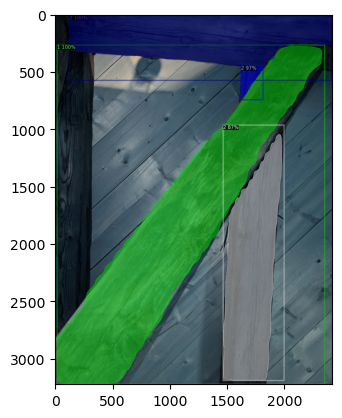

zsh:1: command not found: Folder


In [16]:
cfg = get_cfg()
cfg.merge_from_file("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/config.yaml")
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth"


predictor = DefaultPredictor(cfg)

# ! Single test
image_path = r"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_18_0025.jpeg"
output_folder = f"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output"
visualize_single_image(image_path, cfg, predictor, output_folder)

! Folder test
# input_folder = '/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/2024_07_09_09_57_14'
# output_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output'
# process_folder(input_folder, output_folder, cfg, predictor)

# Read image and segmented area

In [26]:
# ! Rectangle
# image_path = f"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_2_0070_jpeg.rf.f6b63d3d61757bb631819d5e228ffe1f.jpg"
# image_org = cv2.imread(image_path)
# image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_2_0070_jpeg.rf.f6b63d3d61757bb631819d5e228ffe1f.jpg")


# with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_2_0070_jpeg.json") as f:
#     data = json.load(f)

# ! Quadrilateral

# image_org = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_14_0013_jpeg.rf.bab0f2a77774acd744a9c7b5b864a6b5.jpg")
# image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_14_0013_jpeg.rf.bab0f2a77774acd744a9c7b5b864a6b5.jpg")

# with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_14_0013_jpeg.json") as f:
#     data = json.load(f)

! Not Quadrilateral

image_path = r"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_18_0025.jpeg"

image_org = cv2.imread(image_path)

with open(f"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output/test_Model_18_0025.json") as f:
    data = json.load(f)

# ! test

# image_path = r"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/IMG_0003.jpeg"
# image_org = cv2.imread(image_path)
# image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output/test_IMG_0003.jpeg")

# with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output/test_IMG_0003.json") as f:
#     data = json.load(f)

seg_output = data
class_map = {1: "other", 2: "main_beam"}

print(seg_output)


zsh:1: command not found: Not
{'file_name': 'test_Model_18_0025.jpeg', 'instances': [{'class': 2, 'box': [154.8279571533203, 17.522445678710938, 3009.787353515625, 723.4176025390625], 'score': 0.9988934397697449, 'mask': [{'polygon': [[200, 18], [199, 19], [193, 19], [192, 20], [187, 20], [186, 21], [182, 21], [181, 22], [178, 22], [177, 23], [174, 23], [173, 24], [170, 24], [169, 25], [167, 25], [166, 26], [164, 26], [163, 27], [162, 27], [161, 28], [159, 28], [158, 29], [157, 29], [156, 30], [156, 31], [155, 32], [155, 358], [156, 359], [156, 361], [157, 362], [157, 365], [158, 366], [158, 368], [159, 369], [159, 371], [160, 372], [160, 374], [161, 375], [161, 377], [162, 378], [162, 380], [163, 381], [163, 382], [164, 383], [165, 383], [166, 384], [168, 384], [169, 385], [170, 385], [171, 386], [173, 386], [174, 387], [176, 387], [177, 388], [179, 388], [180, 389], [182, 389], [183, 390], [186, 390], [187, 391], [190, 391], [191, 392], [195, 392], [196, 393], [200, 393], [201, 394],

## select max area

In [28]:
#FUNCTION: Select the mask with the largest area using Shoelace formula

def polygon_area(polygon):
    polygon = np.array(polygon)
    x = polygon[:, 0]
    y = polygon[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    
max_area = 0
max_area_index = -1

for i, instance in enumerate(seg_output['instances']):
    polygons = instance['mask']
    for j, polygon_data in enumerate(polygons):
        polygon = polygon_data['polygon']
        area = polygon_area(polygon)
        print(f"Mask_{i}_{j} area: {area}")
        if area > max_area:
            max_area = area
            max_area_index = f"Mask_{i}_{j}"
            max_polygon = polygon

print(f"Largest mask index: {max_area_index}, area: {max_area}")

largest_polygon = max_polygon
print(largest_polygon)

Mask_0_0 area: 1243437.5
Mask_1_0 area: 2826700.0
Mask_2_0 area: 46322.0
Mask_3_0 area: 1161086.5
Largest mask index: Mask_1_0, area: 2826700.0
[[2568, 351], [2567, 352], [2563, 352], [2562, 353], [2557, 353], [2556, 354], [2552, 354], [2551, 355], [2547, 355], [2546, 356], [2542, 356], [2541, 357], [2537, 357], [2536, 358], [2532, 358], [2531, 359], [2527, 359], [2526, 360], [2523, 360], [2522, 361], [2518, 361], [2517, 362], [2514, 362], [2513, 363], [2510, 363], [2509, 364], [2506, 364], [2505, 365], [2501, 365], [2500, 366], [2497, 366], [2496, 367], [2494, 367], [2493, 368], [2490, 368], [2489, 369], [2486, 369], [2485, 370], [2482, 370], [2481, 371], [2479, 371], [2478, 372], [2475, 372], [2474, 373], [2472, 373], [2471, 374], [2468, 374], [2467, 375], [2465, 375], [2463, 377], [2462, 377], [2459, 380], [2458, 380], [2454, 384], [2453, 384], [2445, 392], [2444, 392], [2440, 396], [2440, 397], [2433, 404], [2433, 405], [2431, 407], [2431, 408], [2428, 411], [2428, 412], [2426, 414

## Plot original polygon

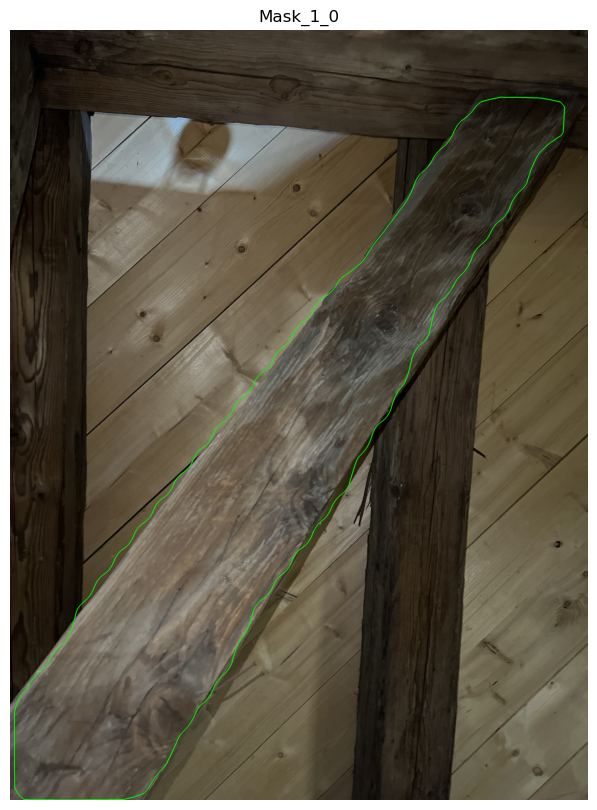

In [29]:
def draw_polygon_on_image(image, polygon):
    pts = np.array(polygon, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=3)
    return image

image_with_polygon = draw_polygon_on_image(image_org.copy(), largest_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_polygon, cv2.COLOR_BGR2RGB))
plt.title(max_area_index)
plt.axis('off')
plt.show()

# plt.imsave("image_with_largest_polygon.jpg", cv2.cvtColor(image_with_polygon, cv2.COLOR_BGR2RGB))


# Abstract complex polygon from the main area to simple polygon

In [30]:
def draw_simple_polygon(image, simplified_polygon):
    pts = np.array(simplified_polygon, np.int32)
    if pts.shape[-1] == 1:
        pts = pts.reshape((-1, 2))
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=3) 
    return image

## Simplify polygon using **Douglas-Peucker** (one shot)

Simplified polygon using Douglas-Peucker algorithm:
[[[ 969    1]]

 [[ 851 1188]]

 [[ 804 3992]]

 [[2180 4021]]

 [[2137  561]]

 [[1979  701]]

 [[1577  776]]

 [[1448  665]]

 [[1326   13]]]


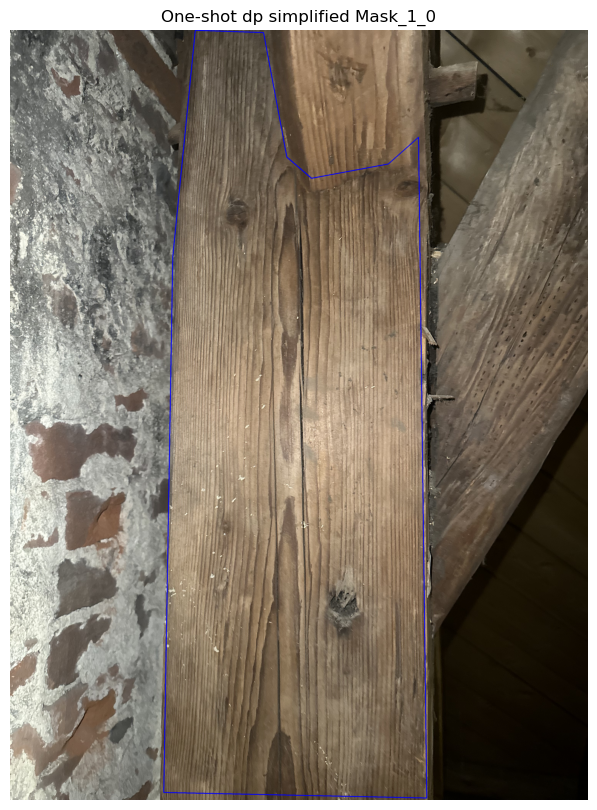

In [7]:
# FUNCTION: Simplify the polygon using Douglas-Peucker algorithm

def dp_simplify(polygon, epsilon_factor=0.006):
    contour = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

dp_simplified_polygon = dp_simplify(largest_polygon)

print("Simplified polygon using Douglas-Peucker algorithm:")
print(dp_simplified_polygon)

image_with_dp_polygon = draw_simple_polygon(image_org.copy(), dp_simplified_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_dp_polygon, cv2.COLOR_BGR2RGB))
plt.title(f"One-shot dp simplified {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_with_dp_polygon.jpg", cv2.cvtColor(image_with_dp_polygon, cv2.COLOR_BGR2RGB))



## Simplify polygon using **Visvalingam–Whyatt**

Simplified polygon using Visvalingam–Whyatt algorithm:
[[9.870e+02 0.000e+00]
 [9.860e+02 1.000e+00]
 [9.690e+02 1.000e+00]
 ...
 [1.278e+03 1.000e+00]
 [1.250e+03 1.000e+00]
 [1.249e+03 0.000e+00]]


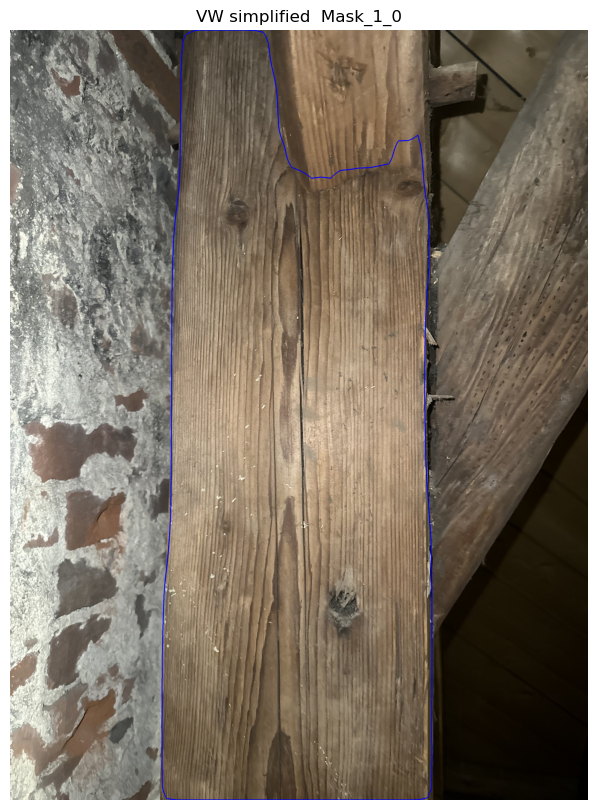

In [8]:
# FUNCTION: Simplified polygon using Visvalingam–Whyatt algorithm

def vw_simplify(polygon, threshold=0.5):
    def area_of_triangle(p1, p2, p3):
        return 0.5 * abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))
    
    points = np.array(polygon, dtype=np.float32)
    is_removed = np.zeros(points.shape[0], dtype=bool)
    areas = np.array([area_of_triangle(points[i - 1], points[i], points[i + 1]) for i in range(1, len(points) - 1)])
    
    while len(areas) > 0 and np.min(areas) < threshold:
        min_index = np.argmin(areas) + 1
        is_removed[min_index] = True
        points = points[~is_removed]
        print(f"Removed point at index {min_index}, remaining points: {len(points)}")
        if len(points) < 3:
            break
        areas = np.array([area_of_triangle(points[i - 1], points[i], points[i + 1]) for i in range(1, len(points) - 1)])
        print(f"Recomputed areas: {areas}")
    return points

vw_simplified_polygon = vw_simplify(largest_polygon)

print("Simplified polygon using Visvalingam–Whyatt algorithm:")
print(vw_simplified_polygon)

image_with_vw_polygon = draw_simple_polygon(image_org.copy(), vw_simplified_polygon)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_vw_polygon, cv2.COLOR_BGR2RGB))
plt.title(f"VW simplified  {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_with_vw_polygon.jpg", cv2.cvtColor(image_with_vw_polygon, cv2.COLOR_BGR2RGB))


## Simplify polygon using **convex_hull**

[[[1249    0]]

 [[1278    1]]

 [[1303    6]]

 [[1321   10]]

 [[1324   11]]

 [[2133  550]]

 [[2134  552]]

 [[2137  561]]

 [[2139  568]]

 [[2144  588]]

 [[2146  597]]

 [[2148  607]]

 [[2152  631]]

 [[2154  645]]

 [[2186  940]]

 [[2187  963]]

 [[2188  987]]

 [[2190 1039]]

 [[2191 1067]]

 [[2192 1133]]

 [[2207 2912]]

 [[2207 3833]]

 [[2206 3901]]

 [[2205 3959]]

 [[2203 3969]]

 [[2201 3977]]

 [[2199 3984]]

 [[2194 3999]]

 [[2192 4004]]

 [[2185 4018]]

 [[2183 4020]]

 [[2180 4021]]

 [[2172 4023]]

 [[2158 4026]]

 [[2148 4028]]

 [[2137 4030]]

 [[2117 4031]]

 [[ 868 4031]]

 [[ 844 4028]]

 [[ 829 4026]]

 [[ 822 4025]]

 [[ 819 4024]]

 [[ 818 4023]]

 [[ 816 4020]]

 [[ 810 4008]]

 [[ 808 4003]]

 [[ 805 3995]]

 [[ 804 3992]]

 [[ 800 3978]]

 [[ 796 3960]]

 [[ 795 3872]]

 [[ 795 3396]]

 [[ 796 3269]]

 [[ 797 3212]]

 [[ 850 1214]]

 [[ 851 1188]]

 [[ 852 1164]]

 [[ 853 1141]]

 [[ 895  192]]

 [[ 896  170]]

 [[ 897  150]]

 [[ 898  131]]

 [[ 899 

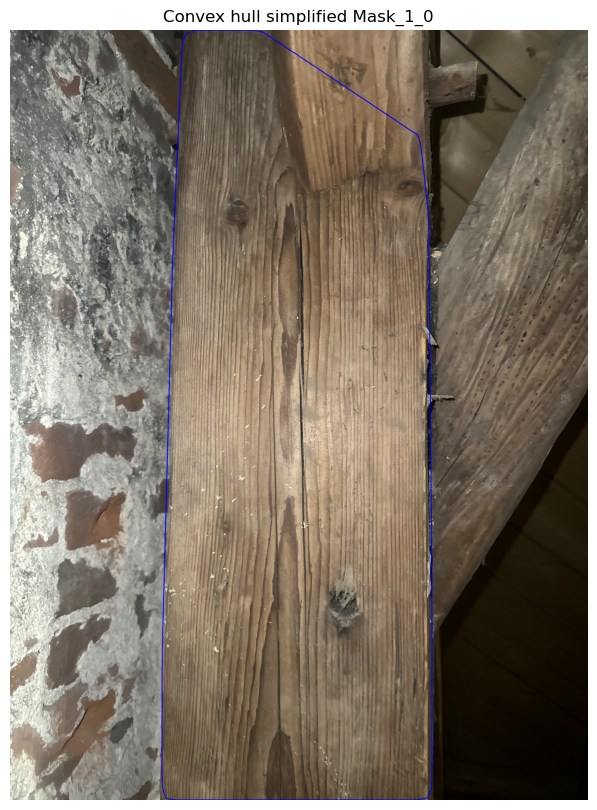

In [9]:
#FUNCTION: convex_hull

def ch_simplify(polygon):
    points = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    hull = cv2.convexHull(points)
    return hull

# simplified_polygon = ch_simplify(dp_simplified_polygon)
simplified_polygon = ch_simplify(vw_simplified_polygon)

print(simplified_polygon)

image_after_ch = draw_simple_polygon(image_org.copy(), simplified_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_after_ch, cv2.COLOR_BGR2RGB))
plt.title(f"Convex hull simplified {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_after_ch.jpg", cv2.cvtColor(image_after_ch, cv2.COLOR_BGR2RGB))



## Find the outer quadrilateral of the polygon using Douglas-Peucker


Best outer quadrilateral: [[[ 969    1]]

 [[2137  561]]

 [[2180 4021]]

 [[ 804 3992]]]


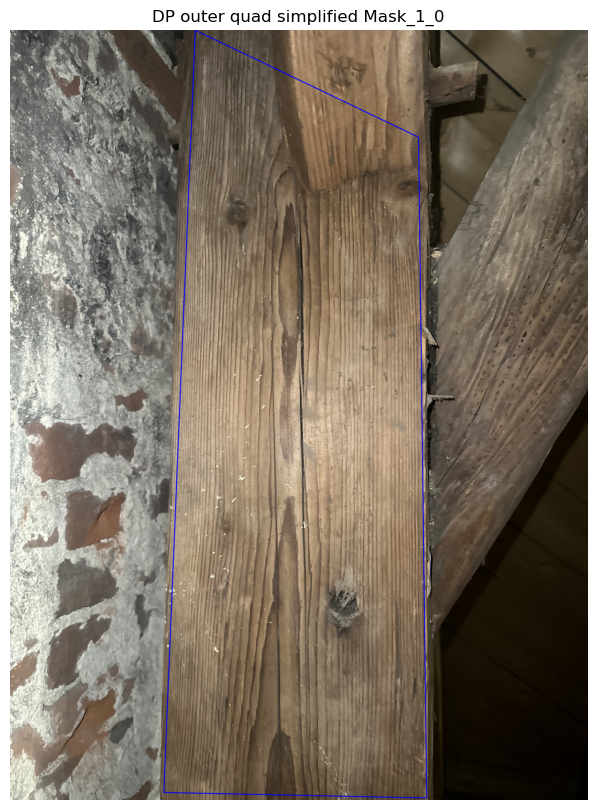

In [10]:
# FUNCTION: Simplify the polygon using Douglas-Peucker algorithm

def dp_simplify(polygon, epsilon_factor=0.006):
    contour = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

optimal_quad_pts = dp_simplify(simplified_polygon, epsilon_factor=0.03)

print("Best outer quadrilateral:", optimal_quad_pts)

optimal_quad_pts = ch_simplify(optimal_quad_pts)

image_outer_quad = draw_simple_polygon(image_org.copy(), optimal_quad_pts)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_outer_quad, cv2.COLOR_BGR2RGB))
plt.title(f"DP outer quad simplified {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_after_ch.jpg", cv2.cvtColor(image_after_ch, cv2.COLOR_BGR2RGB))

# Perspective correction

## Loop calculation (old)

In [17]:
def preprocess_vertices(vertices):
    points = [(v[0][0], v[0][1]) for v in vertices]

    center = np.mean(points, axis=0)
    sorted_points = sorted(points, key=lambda p: (np.arctan2(p[1] - center[1], p[0] - center[0])))
    # print(sorted_points)
    return sorted_points

def polygon_centroid(vertices):
    n = len(vertices)
    if n < 3:
        raise ValueError("A polygon must have at least three vertices")
    
    A = 0
    for i in range(n):
        x0, y0 = vertices[i]
        x1, y1 = vertices[(i + 1) % n]
        A += x0 * y1 - x1 * y0
    A /= 2
    
    Cx = 0
    Cy = 0
    for i in range(n):
        x0, y0 = vertices[i]
        x1, y1 = vertices[(i + 1) % n]
        common_factor = (x0 * y1 - x1 * y0)
        Cx += (x0 + x1) * common_factor
        Cy += (y0 + y1) * common_factor
    Cx /= (6 * A)
    Cy /= (6 * A)
    
    print("centroid success")
    return Cx, Cy

def distance(pt1, pt2):
    print("distance success")
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

def get_vertices_from_quad(vertices, centroid, image_shape):
    dists = [
        distance(vertices[0], vertices[1]),
        distance(vertices[1], vertices[2]),
        distance(vertices[2], vertices[3]),
        distance(vertices[3], vertices[0])
    ]
    print("dists success")

    avg_length = [dists[0] + dists[2], dists[1] + dists[3]]
    print("avg_length success")

    rect = np.array([
        [centroid[0] - avg_length[0] / 2, centroid[1] - avg_length[1] / 2],
        [centroid[0] + avg_length[0] / 2, centroid[1] - avg_length[1] / 2],
        [centroid[0] + avg_length[0] / 2, centroid[1] + avg_length[1] / 2],
        [centroid[0] - avg_length[0] / 2, centroid[1] + avg_length[1] / 2]
    ], dtype="float32")
    
    print("rect array success")
    
    # Adjust rect to fit within image bounds
    width, height = image_shape[1], image_shape[0]
    scale_factor = 1.0
    while True:
        min_x = np.min(rect[:, 0])
        min_y = np.min(rect[:, 1])
        max_x = np.max(rect[:, 0])
        max_y = np.max(rect[:, 1])
        
        if min_x >= 0 and min_y >= 0 and max_x < width and max_y < height:
            break
        
        scale_factor *= 0.80
        rect = np.array([
            [centroid[0] - (avg_length[0] / 2) * scale_factor, centroid[1] - (avg_length[1] / 2) * scale_factor],
            [centroid[0] + (avg_length[0] / 2) * scale_factor, centroid[1] - (avg_length[1] / 2) * scale_factor],
            [centroid[0] + (avg_length[0] / 2) * scale_factor, centroid[1] + (avg_length[1] / 2) * scale_factor],
            [centroid[0] - (avg_length[0] / 2) * scale_factor, centroid[1] + (avg_length[1] / 2) * scale_factor]
        ], dtype="float32")
    
    print("rect success")
    return rect

In [18]:
vertices = preprocess_vertices(optimal_quad_pts)

centroid = polygon_centroid(vertices)
print(f'centroid: ', centroid)

rect = get_vertices_from_quad(vertices, centroid, image_shape=image_org.shape)
print(f'rect: ',rect)

M = cv2.getPerspectiveTransform(np.array(vertices, dtype="float32"), rect)

output_size = (image_org.shape[1], image_org.shape[0])
warped = cv2.warpPerspective(image_org, M, output_size)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

!# save image
base_name, ext = os.path.splitext(os.path.basename(image_path))
output_filename = f'wraped1_{base_name}{ext}'
cv2.imwrite(output_filename, warped)
print(f'Saved warped image to {output_filename}')

/var/folders/tw/kjlfh0gj50z7_jpx3sdvl76h0000gn/T/ipykernel_39836/2181846010.py:27: RuntimeWarning: overflow encountered in scalar multiply
  Cx += (x0 + x1) * common_factor
/var/folders/tw/kjlfh0gj50z7_jpx3sdvl76h0000gn/T/ipykernel_39836/2181846010.py:28: RuntimeWarning: overflow encountered in scalar multiply
  Cy += (y0 + y1) * common_factor


centroid success
centroid:  (-48.3634315901075, 4.247815716594094)
distance success
distance success
distance success
distance success
dists success
avg_length success
rect array success


KeyboardInterrupt: 

## Simplified centroid determination

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_vertices(vertices):
    points = [(v[0][0], v[0][1]) for v in vertices]

    center = np.mean(points, axis=0)
    sorted_points = sorted(points, key=lambda p: (np.arctan2(p[1] - center[1], p[0] - center[0])))
    return sorted_points

def polygon_centroid(vertices):
    vertices = np.array(vertices)
    n = len(vertices)
    if n < 3:
        raise ValueError("A polygon must have at least three vertices")

    A = 0.5 * np.sum(vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1])
    Cx = (1/(6*A)) * np.sum((vertices[:-1, 0] + vertices[1:, 0]) * (vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1]))
    Cy = (1/(6*A)) * np.sum((vertices[:-1, 1] + vertices[1:, 1]) * (vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1]))

    return Cx, Cy

def distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

def get_vertices_from_quad(vertices, centroid, image_shape):
    dists = [
        distance(vertices[0], vertices[1]),
        distance(vertices[1], vertices[2]),
        distance(vertices[2], vertices[3]),
        distance(vertices[3], vertices[0])
    ]

    avg_length = [dists[0] + dists[2], dists[1] + dists[3]]

    rect_width = avg_length[0] / 2
    rect_height = avg_length[1] / 2
    
    # image center
    img_center_x = image_shape[1] / 2
    img_center_y = image_shape[0] / 2

    rect = np.array([
        [img_center_x - rect_width / 2, img_center_y - rect_height / 2],
        [img_center_x + rect_width / 2, img_center_y - rect_height / 2],
        [img_center_x + rect_width / 2, img_center_y + rect_height / 2],
        [img_center_x - rect_width / 2, img_center_y + rect_height / 2]
    ], dtype="float32")
    
    # Adjust rect to fit within image bounds
    rect[:, 0] = np.clip(rect[:, 0], 0, image_shape[1] - 1)
    rect[:, 1] = np.clip(rect[:, 1], 0, image_shape[0] - 1)
    
    return rect




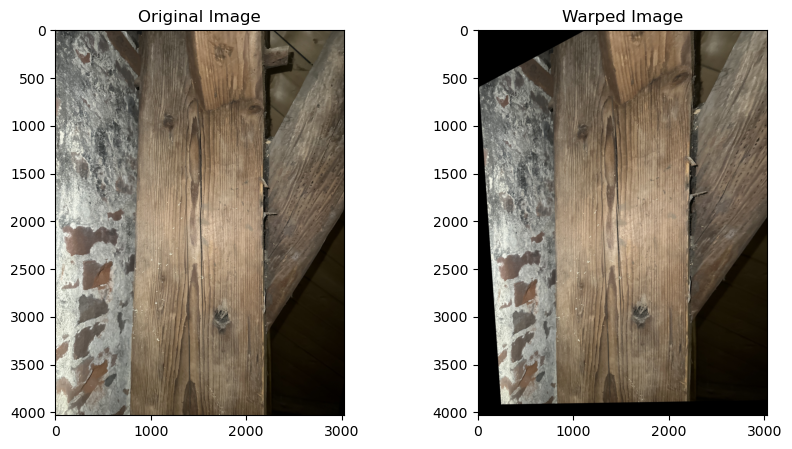

NameError: name 'image_path' is not defined

In [12]:
# scale
scale_factor = 0.5
image_small = cv2.resize(image_org, (0, 0), fx=scale_factor, fy=scale_factor)

# processing vertices
vertices = preprocess_vertices(optimal_quad_pts)
centroid = polygon_centroid(vertices)

# scale vertices and centroid
vertices_small = [(v[0] * scale_factor, v[1] * scale_factor) for v in vertices]
centroid_small = (centroid[0] * scale_factor, centroid[1] * scale_factor)

# transformation matrix
rect_small = get_vertices_from_quad(vertices_small, centroid_small, image_shape=image_small.shape)
M_small = cv2.getPerspectiveTransform(np.array(vertices_small, dtype="float32"), rect_small)

# perspective transformation
output_size_small = (image_small.shape[1], image_small.shape[0])
warped_small = cv2.warpPerspective(image_small, M_small, output_size_small)

# resize back to original size
warped = cv2.resize(warped_small, (image_org.shape[1], image_org.shape[0]))

!# show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

!# save image
base_name, ext = os.path.splitext(os.path.basename(image_path))
output_filename = f'wraped_{base_name}{ext}'
cv2.imwrite(output_filename, warped)
print(f'Saved warped image to {output_filename}')

directory = os.path.dirname(image_path)
output_path = os.path.join(directory, output_filename)
print(f'Output path: {output_path}')

# Detection test

## Test on image


image 1/1 /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/wraped_IMG_0003.jpeg: 640x480 1 wood_knot, 256.7ms
Speed: 3.7ms preprocess, 256.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)
Image saved: /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_detection/wraped_IMG_0003.jpeg


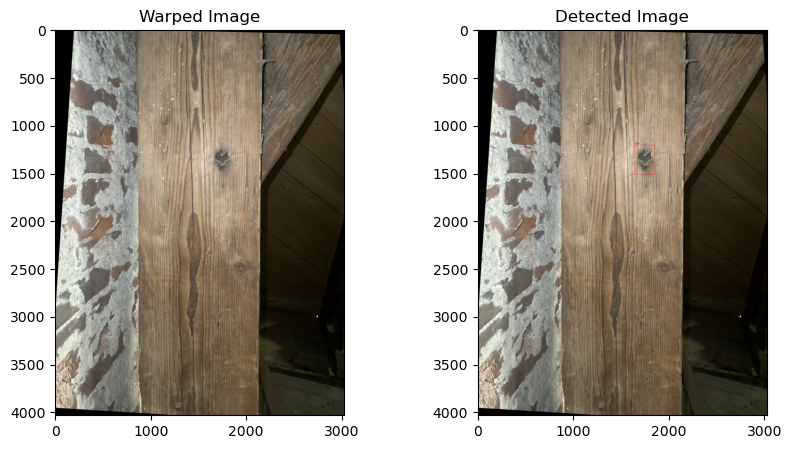

In [27]:
from ultralytics import YOLO
import cv2
import os

model_path = "/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Detection/YOLO/202407_Mixed_tests/Uni-Wood/Mixed_YOLO_d1+sf1_test_1/weights/best.pt"

img_path = output_path 

save_path = "/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_detection"


model = YOLO(model_path)

if not os.path.exists(save_path):
    os.makedirs(save_path)


results = model(img_path)
img = cv2.imread(img_path)

for result in results:
    boxes = result.boxes.cpu().numpy()
    for box in boxes:
        # box contains prediction information
        confidence = box.conf[0]
        if confidence > 0.4:
            xyxy = box.xyxy[0].astype(int)
            confidence_text = f"{confidence:.2f}"

            cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 0, 255), 2)
            cv2.putText(img, confidence_text, (xyxy[0], xyxy[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

unique_save_path = os.path.join(save_path, os.path.basename(img_path))
cv2.imwrite(unique_save_path, img)
print(f"Image saved: {unique_save_path}")

detected = cv2.imread(unique_save_path)

!# show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Detected Image')
plt.imshow(cv2.cvtColor(detected, cv2.COLOR_BGR2RGB))
plt.show()


## Test on folder

In [ ]:
from ultralytics import YOLO
import cv2
import os

model_path = "/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Detection/YOLO/202407_Mixed_tests/Uni-Wood/Mixed_YOLO_d1+sf1_test_1/weights/best.pt"

image_folder = "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/2024_07_09_10_43_56"

save_path = "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/2024_07_09_10_43_56/test"


model = YOLO(model_path)

if not os.path.exists(save_path):
    os.makedirs(save_path)

image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('.jpg', '.jpeg', '.JPG', '.png', '.bmp'))]

for img_path in image_files:
    results = model(img_path)
    img = cv2.imread(img_path)

    for result in results:
        boxes = result.boxes.cpu().numpy()
        for box in boxes:
            # box contains prediction information
            confidence = box.conf[0]
            if confidence > 0.4:
                xyxy = box.xyxy[0].astype(int)
                confidence_text = f"{confidence:.2f}"

                cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 0, 255), 2)
                cv2.putText(img, confidence_text, (xyxy[0], xyxy[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    unique_save_path = os.path.join(save_path, os.path.basename(img_path))
    cv2.imwrite(unique_save_path, img)
    print(f"Image saved: {unique_save_path}")
